# Transcoding a Large Experiment
Contact: andretelfer@cmail.carleton.ca

## Introduction
### What is transcoding and why do we do it?
Transcoding is the process of converting video from one format to another. 

In behavior, this is useful because videos directly from cameras are often overly large. By transcoding we can reduce the size of videos by half or more. Additionally, we can also resize videos (e.g. from 4K resolution to 720p), remove sound, and perform other useful functions. 

In some cases, I have shrunk experiments of over 100GB to <2GB with no difference to scoring. This makes using automated tools, such as deeplabcut, a lot faster. Furthermore it's a lot easier to transfer the files around to students or publish them online. 

### What's covered here
Here we explore a large experiment with an inconsistent structure and lots of irrelevant data

We're going to focus on a few main tasks
1. Exploring the file systems: Finding all of the relevant videos
2. Video details: Getting high level details from them to later verify everything was copied correctly (such as time). We also want to see if the videos themselves are very different and need lots of preprocessing.
3. Transcoding the videos into a new folder using `ffmpeg`

```{note}
In this case, we do not resize the videos because they are fairly low quality. However you can easily add option to the ffmpeg command in the transcoding step to this.
```

### What's not covered here
This notebook is aimed at researchers who already have some knowledge but may want to expand/improve their methods using the tips here

- Python knowledge and some basics including some basic bash is assumed
- knowledge of ffmpeg is helpful
- With some basics, missing knowledge is mostly searchable. 

For questions or suggestions, reach out to me at andretelfer@cmail.carleton.ca

## 1. Exploring the file system

Lets first find which drives are mounted

In [1]:
ls /media/andre

11D9-5C57/  5161-4A93/  9B57-8640/  maternal/


I know that the first 3 drives contain experimental data, the last `maternal` drive is where I plan to store the transcoded videos

In [2]:
from pathlib import Path 

# On my system, this is where the storage devices are mounted
MOUNT_POINT = Path("/media/andre")

# The names of drives the data exists
DRIVES = [
    '11D9-5C57',
    '5161-4A93',
    '9B57-8640'
]

# Where we want to store the videos
OUTPUT_DRIVE = MOUNT_POINT / 'maternal'

### Size of Original Datasets

Lets see how big our original dataset is

In [3]:
%%time

total_size = 0
for drive in DRIVES:
    # glob is a useful tool for searching folders, here we tell it to find every file
    files = (MOUNT_POINT / drive).glob('**/*')
    
    # Only keep the files (discard directories)
    files = list(filter(lambda x: x.is_file(), files)) 
    
    # Get the size of each file
    sizes = list(map(lambda x: x.stat().st_size, files)) 
    size = sum(sizes)
    total_size += size
    
    # print the size in gigabytes
    print(f"Drive {drive} is {size / 1e9:.2f}GB")
    
# print the total size
print(f"Total: {total_size / 1e9:.2f}GB")

Drive 11D9-5C57 is 997.12GB
Drive 5161-4A93 is 491.29GB
Drive 9B57-8640 is 705.03GB
Total: 2193.44GB
CPU times: user 23.5 ms, sys: 31.7 ms, total: 55.2 ms
Wall time: 54.4 ms


### What types of videos are in the dataset

Eek, over 2TB of data. But do we really need all of these files? I only want the videos to transcode, and can ignore everything else

Since videos can have many file extensions, lets print out all of the file extensions so we can identify the video ones.

In [4]:
total_size = 0

# Use a set instead of a list to ignore duplicates
extensions = set()
for drive in DRIVES:
    files = (MOUNT_POINT / drive).glob('**/*')
    files = list(filter(lambda x: x.is_file(), files))
    
    # Get the extensions
    for filepath in files:
        fileparts = filepath.parts[-1].split('.')
        
        # Some files don't have extensions, ignore those
        if len(fileparts) > 1:
            extensions.add(fileparts[-1])

print("Extensions: ", list(extensions))

Extensions:  ['indexUpdates', 'dat', '2', 'Cab', 'indexPositionTable', '_KO16 day 20', 'mp4', 'updates', '_KO152 Day20', 'shadowIndexGroups', 'created', 'zip', 'shadowIndexPositionTable', 'Trashes', 'ini', 'indexCompactDirectory', 'indexPostings', 'indexDirectory', 'indexIds', '_KO112 D15', 'txt', '159', 'plist', 'SnowLeopard', 'db', 'state', '_KO16 day 15', 'shadowIndexCompactDirectory', 'wbcat', 'bin', 'donotpresent', '_KO152 DAY 15', 'shadowIndexHead', '_KO10 DAY 20', '_KO12 day 15', '_WT3 day 15', 'shadow', 'indexBigDates', 'indexTermIds', '_KO15 day 15', '_ko9 day 20', 'indexArrays', 'shadowIndexDirectory', 'indexPositions', '9', '_KO14 day 20', 'wbverify', '_KO10 DAY 15', 'indexHead', 'directoryStoreFile', 'modified', 'shadowIndexTermIds', '1', '10', 'indexGroups', 'shadowIndexArrays', '_KO15 Day 20', 'MPG', 'loc']


### Further narrowing down the videos

Looking through all of the extensions I can see only 2 video related extensions: mp4 and MPG - every other file we can ignore for now

However we may not want all of the videos, sometimes experimenters will horde discarded videos in folders like "temp". Let's make sure we only get videos that appear meaningful. 

... but first lets check how many videos

In [5]:
for drive in DRIVES:
    videos = (
        list((MOUNT_POINT / drive).glob('**/*.mp4')) + 
        list((MOUNT_POINT / drive).glob('**/*.MPG'))
    )
    
    print(f"Number of videos in {drive}: {len(videos)}")

Number of videos in 11D9-5C57: 1102
Number of videos in 5161-4A93: 528
Number of videos in 9B57-8640: 673


Again, eek. But I can't think of a way around seeing them all so lets print them out anyways.

In [6]:
for drive in DRIVES:
    videos = (
        list((MOUNT_POINT / drive).glob('**/*.mp4')) + 
        list((MOUNT_POINT / drive).glob('**/*.MPG'))
    )
    videos = list(map(str, videos)) # makes things a bit prettier
    print(videos)

['/media/andre/11D9-5C57/ch04_20141026223910.mp4', '/media/andre/11D9-5C57/ch04_20141027002615.mp4', '/media/andre/11D9-5C57/._ch02_20141004031546.mp4', '/media/andre/11D9-5C57/ch04_20141027021320.mp4', '/media/andre/11D9-5C57/ch04_20141027040025.mp4', '/media/andre/11D9-5C57/ch04_20141027054731.mp4', '/media/andre/11D9-5C57/ch04_20141027073438.mp4', '/media/andre/11D9-5C57/ch07_20141029182333.mp4', '/media/andre/11D9-5C57/ch07_20141029185404.mp4', '/media/andre/11D9-5C57/ch07_20141029204109.mp4', '/media/andre/11D9-5C57/ch07_20141029222816.mp4', '/media/andre/11D9-5C57/ch07_20141030001521.mp4', '/media/andre/11D9-5C57/ch07_20141030020226.mp4', '/media/andre/11D9-5C57/ch07_20141030034933.mp4', '/media/andre/11D9-5C57/ch07_20141030053638.mp4', '/media/andre/11D9-5C57/ch07_20141030072343.mp4', '/media/andre/11D9-5C57/ch07_20141030091049.mp4', '/media/andre/11D9-5C57/ch07_20141030105756.mp4', '/media/andre/11D9-5C57/ch07_20141030124501.mp4', '/media/andre/11D9-5C57/ch07_20141030143208.mp4

After lots of reading, I can say fairly confidently there are two types of videos we want to ignore
1. Ones that begin with a `.` or are in folders that begin with a `.`. These videos are hidden and are probably artifacts from the camera or some other software.
2. Videos in folders that begin with $RECYCLE, 

For now let's say the rest of the videos are useful, we can sort them out later by viewing them. There are too many to look through each one right now.

In [7]:
def is_visible(filepath):
    for part in filepath.parts:
        if part.startswith('.'):
            return False
        
    return True

def is_not_recycled(filepath):
    for part in filepath.parts:
        if part.startswith('$RECYCLE'):
            return False
        
    return True
    
all_videos = []
for drive in DRIVES:
    videos = (
        list((MOUNT_POINT / drive).glob('**/*.mp4')) + 
        list((MOUNT_POINT / drive).glob('**/*.MPG'))
    )
    
    all_videos_len = len(videos)
    videos = list(filter(is_visible, videos))
    videos = list(filter(is_not_recycled, videos))
    after_filtering_len = len(videos)
    all_videos += videos
    
    print(f"Length of videos before filtering: {all_videos_len:4}, after: {after_filtering_len}")

Length of videos before filtering: 1102, after: 924
Length of videos before filtering:  528, after: 439
Length of videos before filtering:  673, after: 553


### Visualizing structure of folders
Sometimes the folders are very disorganized and its hard to get a big picture of what data we have by looking into each folder one at a time

In [8]:
pip install -q treelib

Note: you may need to restart the kernel to use updated packages.


In [9]:
import treelib
from tqdm import tqdm

tree = treelib.Tree()
tree.create_node('/', '/')
for video in tqdm(all_videos):
    video = video.relative_to(MOUNT_POINT)
    parts = video.parts[:-1] # don't include filename
    for i in range(1,len(parts)+1):
        uid = '/'.join(parts[:i])
        name = parts[i-1]
        
        if tree.contains(uid):
            continue 
        
        # include parent
        if i > 1:
            parent_uid = '/'.join(parts[:i-1])
            tree.create_node(name, uid, parent=parent_uid)
        else:
            tree.create_node(name, uid, parent='/')
            
tree.show()

100%|██████████| 1916/1916 [00:00<00:00, 209512.90it/s]

/
├── 11D9-5C57
│   ├── Day10s
│   │   └── ko10 day 10
│   ├── KO10 DAY 15
│   ├── KO10 DAY 20
│   ├── KO112 D15
│   ├── KO12 day 10
│   ├── KO12 day 15
│   ├── KO14 day 20
│   ├── KO15 Day 20
│   ├── KO15 day 15
│   ├── KO152 DAY 10
│   ├── KO152 DAY 15
│   ├── KO152 Day20
│   ├── KO16 day 15
│   ├── KO16 day 20
│   ├── WT3 DAY 20
│   ├── WT3 day 10
│   ├── WT3 day 15
│   ├── WT6 DAY 20
│   ├── WT72 D15
│   ├── WT72 DAY 10
│   ├── WT72 DAY 15
│   ├── WT72 DAY 20
│   │   └── WT12 D15
│   │       └── WT12 day 15
│   ├── WT8 DAY 15
│   ├── WT8 day 20
│   ├── WT82 D10
│   ├── WT82 D20
│   ├── WT82 DAY 15
│   ├── WT82 DAY 20
│   ├── ko9 day 20
│   └── wt6 day 15
├── 5161-4A93
│   ├── Day10s
│   ├── KO112 D15
│   ├── KO15 Day 20
│   ├── KO15 day 15
│   ├── KO9 Day 20
│   ├── WT72 D15
│   ├── WT72 Day 20
│   │   └── WT12 D15
│   │       └── WT12 day 15
│   ├── WT8 Day 15
│   └── WT82 D20
└── 9B57-8640
    ├── AVIDEOS
    │   └── stef videos
    ├── KO10 day 10
    ├── KO11 day 20
    ├── KO1

We can save the whole output to a file to view it there

## 2. Video Details

### Getting Video Metadata

So we know how many videos are in each folder, and how big the files are. But how long are the videos? Are they all the same size? (this can be very important because many algorithms struggle with inconsistent scales)

Knowing this metadata is also important because it can help us validate the transcoded videos later.

In [10]:
import pandas as pd
import cv2
from tqdm import tqdm

metadata = []
for video in tqdm(all_videos):
    cap = cv2.VideoCapture(str(video))
    _metadata = {
        'file': video,
        'filetype': video.parts[-1].split('.')[-1],
        'frames': int(cap.get(cv2.CAP_PROP_FRAME_COUNT)),
        'fps': float(cap.get(cv2.CAP_PROP_FPS)),
        'width': int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
        'height': int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    }
    metadata.append(_metadata)
    
metadata_df = pd.DataFrame(metadata)
metadata_df

100%|██████████| 1916/1916 [02:42<00:00, 11.78it/s] 


,file,filetype,frames,fps,width,height
0,/media/andre/11D9-5C57/ch04_20141026223910.mp4,mp4,192676,30.00000,704,480
1,/media/andre/11D9-5C57/ch04_20141027002615.mp4,mp4,192706,30.00000,704,480
2,/media/andre/11D9-5C57/ch04_20141027021320.mp4,mp4,192706,30.00000,704,480
3,/media/andre/11D9-5C57/ch04_20141027040025.mp4,mp4,192708,30.00000,704,480
4,/media/andre/11D9-5C57/ch04_20141027054731.mp4,mp4,192736,30.00000,704,480
...,...,...,...,...,...,...
1911,/media/andre/9B57-8640/AVIDEOS/stef videos/M2U...,MPG,94226,29.97003,720,480
1912,/media/andre/9B57-8640/AVIDEOS/stef videos/M2U...,MPG,94331,29.97003,720,480
1913,/media/andre/9B57-8640/AVIDEOS/stef videos/M2U...,MPG,94437,29.97003,720,480
1914,/media/andre/9B57-8640/AVIDEOS/stef videos/M2U...,MPG,94362,29.97003,720,480


### Total duration

In [11]:
(metadata_df.frames / metadata_df.fps).sum()

-307445721479635.5

... That doesn't look right. What's going on?

In [12]:
metadata_df.describe()

,frames,fps,width,height
count,1.916000e+03,1916.000000,1916.000000,1916.0
mean,-4.813868e+12,29.999531,704.250522,480.0
std,1.215918e+14,0.003722,1.986869,0.0
min,-3.074457e+15,29.970030,704.000000,480.0
25%,1.927070e+05,30.000000,704.000000,480.0
50%,1.927090e+05,30.000000,704.000000,480.0
75%,1.927380e+05,30.000000,704.000000,480.0
max,2.101409e+06,30.000000,720.000000,480.0


Apparently the minimum number of frames for a video is `-3.074457e+15`... clearly there was a problem there. 

Let's see what videos are causing the problem

In [13]:
metadata_df.loc[metadata_df.frames < 0]

,file,filetype,frames,fps,width,height
122,/media/andre/11D9-5C57/KO12 day 15/ch05_201503...,mp4,-3074457345618259,30.0,704,480
1143,/media/andre/5161-4A93/ch05_20150308203728 - C...,mp4,-3074457345618259,30.0,704,480
1519,/media/andre/9B57-8640/WT6/WT6 day 15 (9).mp4,mp4,-3074457345618259,30.0,704,480


Bad videos. Fortunately there's only a few so we can ignore them and deal with them manually later. Hopefully transcoding them will correct it.

In [14]:
outlier_rows = metadata_df.frames < 0
metadata_df.loc[outlier_rows, 'frames'] = None
metadata_df.loc[outlier_rows]

,file,filetype,frames,fps,width,height
122,/media/andre/11D9-5C57/KO12 day 15/ch05_201503...,mp4,NaN,30.0,704,480
1143,/media/andre/5161-4A93/ch05_20150308203728 - C...,mp4,NaN,30.0,704,480
1519,/media/andre/9B57-8640/WT6/WT6 day 15 (9).mp4,mp4,NaN,30.0,704,480


Great! we can get the total duration

In [15]:
(metadata_df.frames / metadata_df.fps).sum()

13082190.523133334

In human language...

In [16]:
total_seconds = (metadata_df.frames / metadata_df.fps).sum()
total_days = total_seconds / 60 / 60 / 24 # 60s->1m, 60m->1h, 24h->1d
print(f"Total days of videos: {total_days:.1f}")

Total days of videos: 151.4


Lets consider ourselves fortunate we're not going to score this manually. Scoring just a few hours of videos is a slow process already, scoring 151 days of video would probably take an entire PhD

### Any other differences in size, etc?

In [17]:
metadata_df.describe()

,frames,fps,width,height
count,1.913000e+03,1916.000000,1916.000000,1916.0
mean,2.051559e+05,29.999531,704.250522,480.0
std,1.025081e+05,0.003722,1.986869,0.0
min,1.620000e+02,29.970030,704.000000,480.0
25%,1.927070e+05,30.000000,704.000000,480.0
50%,1.927090e+05,30.000000,704.000000,480.0
75%,1.927380e+05,30.000000,704.000000,480.0
max,2.101409e+06,30.000000,720.000000,480.0


All of the videos have exactly the same height, and pretty much the same fps. There are videos with different widths however. Lets see all of the widths.

In [18]:
metadata_df.width.unique()

array([704, 720])

Only two video widths, 704px and 720px. Lets see if these are from the two different filetypes `mp4` and `MPG`

In [19]:
metadata_df.loc[metadata_df.width==704].describe()

,frames,fps,width,height
count,1.883000e+03,1886.0,1886.0,1886.0
mean,2.071501e+05,30.0,704.0,480.0
std,1.020346e+05,0.0,0.0,0.0
min,1.620000e+02,30.0,704.0,480.0
25%,1.927070e+05,30.0,704.0,480.0
50%,1.927090e+05,30.0,704.0,480.0
75%,1.927380e+05,30.0,704.0,480.0
max,2.101409e+06,30.0,704.0,480.0


In [20]:
metadata_df.loc[metadata_df.width==704].sample(3)

,file,filetype,frames,fps,width,height
1369,/media/andre/9B57-8640/WT2/WT2 day 20 (3).mp4,mp4,318255.0,30.0,704,480
695,/media/andre/11D9-5C57/KO10 DAY 20/KO10 Day 20...,mp4,192677.0,30.0,704,480
626,/media/andre/11D9-5C57/WT3 DAY 20/WT3 day 20 (...,mp4,192677.0,30.0,704,480


In [21]:
metadata_df.loc[metadata_df.width==720].describe()

,frames,fps,width,height
count,30.000000,3.000000e+01,30.0,30.0
mean,79989.800000,2.997003e+01,720.0,480.0
std,26287.615716,7.226896e-15,0.0,0.0
min,3221.000000,2.997003e+01,720.0,480.0
25%,80380.250000,2.997003e+01,720.0,480.0
50%,94297.500000,2.997003e+01,720.0,480.0
75%,94458.000000,2.997003e+01,720.0,480.0
max,94561.000000,2.997003e+01,720.0,480.0


In [22]:
metadata_df.loc[metadata_df.width==720].sample(3)

,file,filetype,frames,fps,width,height
1908,/media/andre/9B57-8640/AVIDEOS/M2U00193.MPG,MPG,94227.0,29.97003,720,480
1897,/media/andre/9B57-8640/AVIDEOS/M2U00182.MPG,MPG,33790.0,29.97003,720,480
1900,/media/andre/9B57-8640/AVIDEOS/M2U00185.MPG,MPG,94496.0,29.97003,720,480


Yep! At a glance it looks like the mp4 files have a width of 704 and all of the MPG files have a width of 720.

I'm pretty satisfied with understanding the videos at this point. The differences in videos appear minor, likely due to a camera change. We also know that when we finish transcoding we expect our new videos to have a total duration of about 13082190 seconds.

We also identified a few videos that may be damaged which we can manually check over later.

## 3. Transcoding the videos

In [23]:
print(f"We're not going to reorganize our {len(all_videos)} videos here.")

We're not going to reorganize our 1916 videos here.


Instead we'll just transcode them over in their original structure for now. The transcoded videos will still be smaller, and we can safely manually reorganize them without risking losing anything since we still have the originals.

### Creating a bash file for long runs

The following script generates a bash file that can be run to transcode all of the files

The tool we use to actually do the transcoding is called ffmpeg. It's very versatile, and has way too many options to learn all of them, so you can search up what you need when you need them.

ffmpeg commands don't have to be complicated, a simple one would be 
```bash
ffmpeg -i <your-input-file> <your-output-file>
```

We can do things like resizing the video or changing quality, in the below command I decrease the video quality slightly using `-crf 24`. This should shrinkg their size a lot.

In [24]:
import re

with open('transcode.sh', 'w') as fp:
    lines = []
    for video in all_videos:
        relative_path = video.relative_to(MOUNT_POINT)
        output_filepath = OUTPUT_DRIVE / relative_path
        
        # For now lets skip existing filepaths
        if output_filepath.exists():
            continue
        
        cmd = (
            "mkdir -p {output_dir} && " # make a new directory if necessary
            "ffmpeg -y -hwaccel cuda -hwaccel_output_format cuda -extra_hw_frames 4 -i {input_file} " # the input file and flags
            "-c:v h264_nvenc -crf 24 -an {output_file}\n" # the output file and flags
        ).format(
            output_dir=re.escape(str(output_filepath.parent)), 
            input_file=re.escape(str(video)), 
            output_file=re.escape(str(output_filepath))
        ) 
        
        lines.append(cmd)
        
    fp.writelines(lines)

This is what the bash file looks like (but a lot more lines)

In [25]:
! head -n 3 transcode.sh

mkdir -p /media/andre/maternal/11D9\-5C57 && ffmpeg -y -hwaccel cuda -hwaccel_output_format cuda -extra_hw_frames 4 -i /media/andre/11D9\-5C57/ch07_20141029222816\.mp4 -c:v h264_nvenc -crf 24 -an /media/andre/maternal/11D9\-5C57/ch07_20141029222816\.mp4
mkdir -p /media/andre/maternal/11D9\-5C57 && ffmpeg -y -hwaccel cuda -hwaccel_output_format cuda -extra_hw_frames 4 -i /media/andre/11D9\-5C57/ch07_20141030001521\.mp4 -c:v h264_nvenc -crf 24 -an /media/andre/maternal/11D9\-5C57/ch07_20141030001521\.mp4
mkdir -p /media/andre/maternal/11D9\-5C57 && ffmpeg -y -hwaccel cuda -hwaccel_output_format cuda -extra_hw_frames 4 -i /media/andre/11D9\-5C57/ch07_20141030020226\.mp4 -c:v h264_nvenc -crf 24 -an /media/andre/maternal/11D9\-5C57/ch07_20141030020226\.mp4


I've now started running this bash script. I'll see you in a few days!

### Verifying videos
... Well, I'm a bit impatient, so I'm not going to wait a few days. Let's check to see how things are going after a few hours.

We expect some differences
- One video to not match/be readable as the bash script is still running and transcoding away as I write this.
- Other videos will be a few frames off, often some frames are dropped during transcoding

In [26]:
transcoded_videos = (
    list(OUTPUT_DRIVE.glob('**/*.mp4')) + 
    list(OUTPUT_DRIVE.glob('**/*.MPG'))
)

metadata = []
for transcoded_video in tqdm(transcoded_videos):
    relative_path = transcoded_video.relative_to(OUTPUT_DRIVE)
    original_video = MOUNT_POINT / relative_path
    
    original_cap = cv2.VideoCapture(str(original_video))
    transcoded_cap = cv2.VideoCapture(str(transcoded_video))
    
    _metadata = {
        'file': original_video,
        'transcoded_file': transcoded_video,
        'frames': int(original_cap.get(cv2.CAP_PROP_FRAME_COUNT)),
        'transcoded_frames': int(transcoded_cap.get(cv2.CAP_PROP_FRAME_COUNT)),
        'filesize_mb': round(original_video.stat().st_size / 1e6, 1), 
        'transcoded_filesize_mb': round(transcoded_video.stat().st_size / 1e6, 1), 
    }
    metadata.append(_metadata)
    
transcoded_metadata_df = pd.DataFrame(metadata)
transcoded_metadata_df

100%|██████████| 9/9 [00:01<00:00,  5.96it/s]


,file,transcoded_file,frames,transcoded_frames,filesize_mb,transcoded_filesize_mb
0,/media/andre/11D9-5C57/ch04_20141026223910.mp4,/media/andre/maternal/11D9-5C57/ch04_201410262...,192676,192485,1066.0,320.0
1,/media/andre/11D9-5C57/ch04_20141027002615.mp4,/media/andre/maternal/11D9-5C57/ch04_201410270...,192706,192515,1066.2,332.7
2,/media/andre/11D9-5C57/ch04_20141027021320.mp4,/media/andre/maternal/11D9-5C57/ch04_201410270...,192706,192515,1066.2,245.2
3,/media/andre/11D9-5C57/ch04_20141027040025.mp4,/media/andre/maternal/11D9-5C57/ch04_201410270...,192708,192517,1066.2,266.4
4,/media/andre/11D9-5C57/ch04_20141027054731.mp4,/media/andre/maternal/11D9-5C57/ch04_201410270...,192736,192545,1066.3,252.6
5,/media/andre/11D9-5C57/ch04_20141027073438.mp4,/media/andre/maternal/11D9-5C57/ch04_201410270...,57074,57019,315.8,220.9
6,/media/andre/11D9-5C57/ch07_20141029182333.mp4,/media/andre/maternal/11D9-5C57/ch07_201410291...,55063,55010,304.6,458.9
7,/media/andre/11D9-5C57/ch07_20141029185404.mp4,/media/andre/maternal/11D9-5C57/ch07_201410291...,192710,192519,1066.1,1320.8
8,/media/andre/11D9-5C57/ch07_20141029204109.mp4,/media/andre/maternal/11D9-5C57/ch07_201410292...,192738,0,1066.2,153.1


#### Quality checks

##### Comparing individual frames
Unfortunately these don't match up exactly because a number of frames are dropped during transcoding

There are ways around this, but the underlying problem was with the original videos in this case so I just let ffmpeg correct them as it saw necessary. In total only a few seconds are lost from around 2h of video.

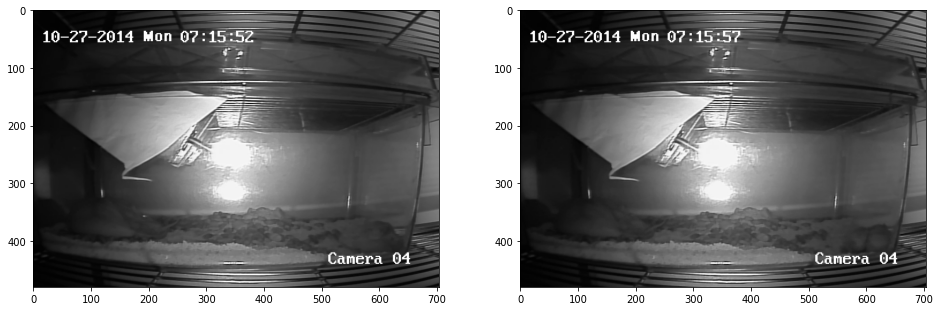

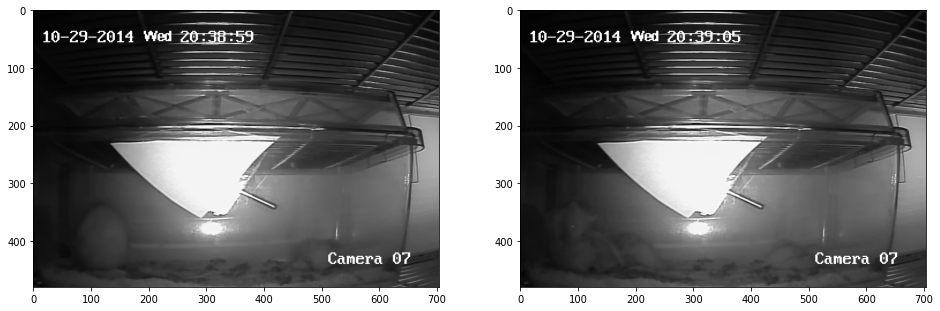

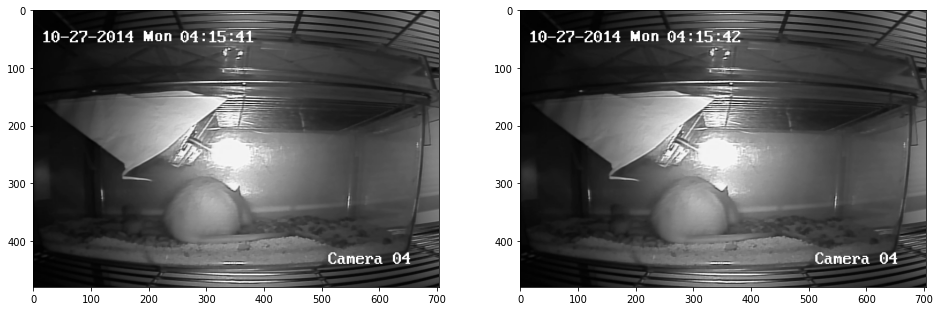

In [28]:
import numpy as np
import matplotlib.pyplot as plt

for idx, row in transcoded_metadata_df.sample(3).iterrows():
    frames = min(row.transcoded_frames, row.frames)
    frame_idx = np.random.randint(frames)
    
    original_cap = cv2.VideoCapture(str(row.file))
    original_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    
    transcoded_cap = cv2.VideoCapture(str(row.transcoded_file))
    transcoded_cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    
    plt.figure(figsize=(16, 8))
    gs = plt.GridSpec(1, 2)
    plt.subplot(gs[0])
    ret, frame = original_cap.read()
    frame = np.flip(frame, axis=2)
    plt.imshow(frame)
    
    plt.subplot(gs[1])
    ret, frame = transcoded_cap.read()
    frame = np.flip(frame, axis=2)
    plt.imshow(frame)
    
    plt.show()

#### Stacking videos

```
ffmpeg -i original.mp4 -i transcoded.mp4 -filter_complex vstack=inputs=2 stacked-view.mp4
```